### 8. juli 

Hvilken fordeling har vektendringene som skjer over tid i det første laget til det nevrale nettverket definert i koden under? Det prøver jeg å finne ut. 

Er det en eksponentialfordeling?
$$P(\Delta w) = C e^{-\frac{\Delta w}{\Delta w^*}}$$
hvor $\Delta w$ er vektendringen, $C$ er en konstant og $\Delta w^*$ er den karakteristiske lengden/størrelsen.

en logaritmisk fordeling?
$$\log_{10} P = \log_{10} C - \frac{\Delta w}{\Delta w^*}$$

eller en log-normal-fordeling?
$$\ln P \rightarrow e^{-\frac{1}{2}(\frac{x-\mu}{\sigma})^2}$$


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange

Tester litt hvordan eksponentialfunksjonen oppfører seg med ulike input:

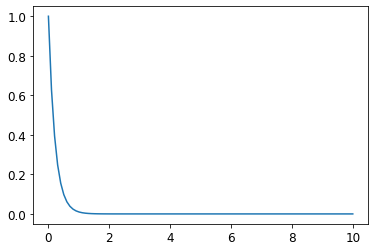

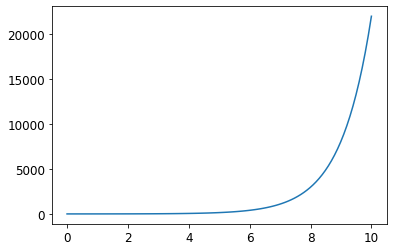

In [141]:
x = np.linspace(0, 10, 100)
def f(x, a):
    return a**x

def g(x):
    return np.exp(x)

plt.plot(x, f(x, 0.01))
plt.show()
plt.plot(x, g(x))
plt.show()

Tester log-funksjonen med ulike input:

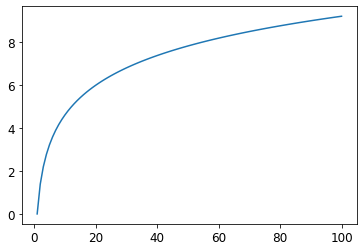

In [142]:
x = np.linspace(1, 100, 100)
def f(x, a):
    return a * np.log((x))

plt.plot(x, f(x, 2))
plt.show()

Hyperparameterne er like de fra 01-04_07_23.ipynb, da jeg i denne notebooken ønsker å se videre på sannsynlighetstetthetene og hvilken funksjon de kan passe. Jeg velger her å utelate histogrammene i plottingen, men ellers er koden helt lik.

In [3]:
# Hyperparameters
input_dim = 28**2  # MNIST images are 28x28 pixels
hidden_dim1 = 28**2 #128  # Number of units in the first hidden layer
hidden_dim2 = 28**2 #100  # Number of units in the second hidden layer
learning_rate = 0.01
output_dim = 10  # Initial output classes 
batch_size = 64

In [4]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(input_dim, hidden_dim1)
        self.layer2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.layer3 = nn.Linear(hidden_dim2, output_dim)
        self.R = nn.ReLU()

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.R(self.layer1(x))
        x = self.R(self.layer2(x))
        x = self.layer3(x)
        return x

In [5]:
# Normalizes the data like I did earlier by dividing by 255.0
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [6]:
# Create an instance of the network
model = Net()

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [7]:
# Set random seed for reproducibility
torch.manual_seed(43)

num_epochs = 30

# Track the weight differences
weight_differences_0_1 = []
weight_differences_9_10 = []
weight_differences_29_30 = []
initial_weights = None


In [8]:
# Training loop
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Save the weight differences for the desired epochs
    if epoch == 0:
        initial_weights = model.layer1.weight.data.clone()
    elif epoch == 1:
        final_weights = model.layer1.weight.data.clone()
        weight_diff = torch.abs(final_weights - initial_weights)
        weight_differences_0_1.extend(weight_diff.view(-1).detach().numpy())
    elif epoch == 9:
        final_weights = model.layer1.weight.data.clone()
        weight_diff = torch.abs(final_weights - initial_weights)
        weight_differences_9_10.extend(weight_diff.view(-1).detach().numpy())
    elif epoch == 29:
        final_weights = model.layer1.weight.data.clone()
        weight_diff = torch.abs(final_weights - initial_weights)
        weight_differences_29_30.extend(weight_diff.view(-1).detach().numpy())

    print(f"Epoch [{epoch + 1}/{num_epochs}]")


Epoch [1/30]
Epoch [2/30]
Epoch [3/30]
Epoch [4/30]
Epoch [5/30]
Epoch [6/30]
Epoch [7/30]
Epoch [8/30]
Epoch [9/30]
Epoch [10/30]
Epoch [11/30]
Epoch [12/30]
Epoch [13/30]
Epoch [14/30]
Epoch [15/30]
Epoch [16/30]
Epoch [17/30]
Epoch [18/30]
Epoch [19/30]
Epoch [20/30]
Epoch [21/30]
Epoch [22/30]
Epoch [23/30]
Epoch [24/30]
Epoch [25/30]
Epoch [26/30]
Epoch [27/30]
Epoch [28/30]
Epoch [29/30]
Epoch [30/30]


In [42]:
plt.rcParams.update({'font.size': 12})

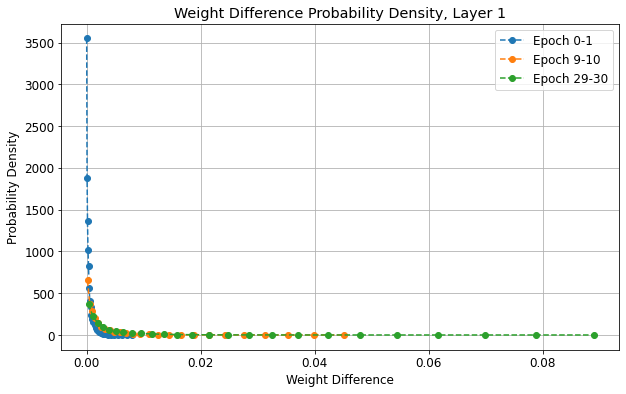

In [57]:
# Define the number of bins and the scaling factor for increasing bin widths
num_bins = 25
bin_width_scale = 15

# Calculate the scaling factor for each bin
bin_scaling = np.exp(np.linspace(0, np.log(bin_width_scale), num_bins))

# Insert 0 as the first element of bin_scaling
bin_scaling = np.insert(bin_scaling, 0, 0)

# Calculate the bin edges
bin_edges = np.cumsum(bin_scaling)
bin_edges /= bin_edges[-1]
bin_edges *= np.max(weight_differences_0_1)  # Use the maximum weight difference from epoch 0-1

# Calculate probability density for epoch 0-1
hist_0_1, _ = np.histogram(weight_differences_0_1, bins=bin_edges, density=False)
bin_centers_0_1 = (bin_edges[:-1] + bin_edges[1:]) / 2
bin_widths_0_1 = np.diff(bin_edges)
prob_density_0_1 = hist_0_1 / (bin_widths_0_1 * np.sum(hist_0_1))

# Repeat the same process for epoch 9-10
bin_edges = np.cumsum(bin_scaling)
bin_edges /= bin_edges[-1]
bin_edges *= np.max(weight_differences_9_10)  # Use the maximum weight difference from epoch 9-10

# Calculate probability density for epoch 9-10
hist_9_10, _ = np.histogram(weight_differences_9_10, bins=bin_edges, density=False)
bin_centers_9_10 = (bin_edges[:-1] + bin_edges[1:]) / 2
bin_widths_9_10 = np.diff(bin_edges)
prob_density_9_10 = hist_9_10 / (bin_widths_9_10 * np.sum(hist_9_10))

# Repeat the same process for epoch 29-30
bin_edges = np.cumsum(bin_scaling)
bin_edges /= bin_edges[-1]
bin_edges *= np.max(weight_differences_29_30)  # Use the maximum weight difference from epoch 29-30

# Calculate probability density for epoch 29-30
hist_29_30, _ = np.histogram(weight_differences_29_30, bins=bin_edges, density=False)
bin_centers_29_30 = (bin_edges[:-1] + bin_edges[1:]) / 2
bin_widths_29_30 = np.diff(bin_edges)
prob_density_29_30 = hist_29_30 / (bin_widths_29_30 * np.sum(hist_29_30))

# Plot all histograms and probability functions in one plot
plt.figure(figsize=(10, 6))

# Plot the probability density curves
plt.plot(bin_centers_0_1, prob_density_0_1, "o--", label="Epoch 0-1")
plt.plot(bin_centers_9_10, prob_density_9_10, "o--", label="Epoch 9-10")
plt.plot(bin_centers_29_30, prob_density_29_30, "o--", label="Epoch 29-30")

plt.xlabel("Weight Difference, $\Delta w$")
plt.ylabel("Probability Density")
plt.title("Weight Difference Probability Density, Layer 1")
plt.legend()
plt.grid()
plt.show()

Som vi ser, er det kun et mindre område hvor vi ser alle de tre sannsynlighetstetthetene. Zoomer derfor inn på dette området:

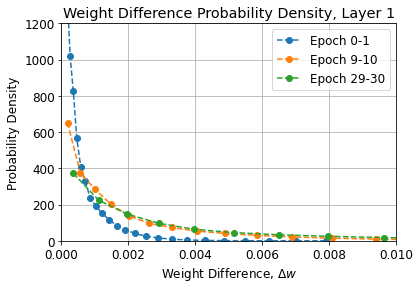

In [146]:
plt.plot(bin_centers_0_1, prob_density_0_1, "o--", label="Epoch 0-1")
plt.plot(bin_centers_9_10, prob_density_9_10, "o--", label="Epoch 9-10")
plt.plot(bin_centers_29_30, prob_density_29_30, "o--", label="Epoch 29-30")

plt.xlabel("Weight Difference, $\Delta w$")
plt.ylabel("Probability Density")
plt.title("Weight Difference Probability Density, Layer 1")
plt.legend()
plt.grid()
plt.xlim(0, 0.01)
plt.ylim(0, 1200)
plt.show()

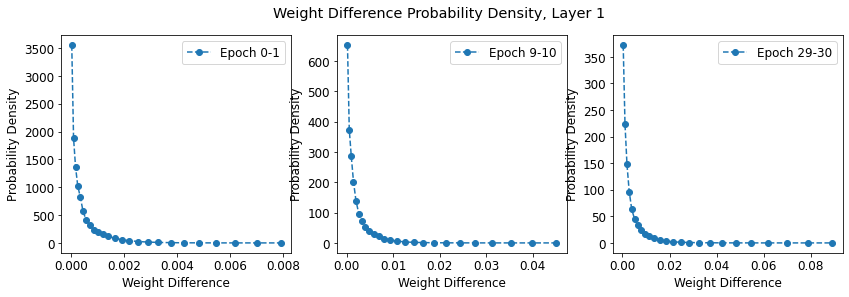

In [60]:
plt.figure(figsize=(14, 4))
plt.suptitle("Weight Difference Probability Density, Layer 1")

plt.subplot(1, 3, 1)
plt.plot(bin_centers_0_1, prob_density_0_1, "o--", label="Epoch 0-1")
plt.legend()
plt.xlabel("Weight Difference, $\Delta w$")
plt.ylabel("Probability Density")

plt.subplot(1, 3, 2)
plt.plot(bin_centers_9_10, prob_density_9_10, "o--", label="Epoch 9-10")
plt.legend()
plt.xlabel("Weight Difference, $\Delta w$")
plt.ylabel("Probability Density")

plt.subplot(1, 3, 3)
plt.plot(bin_centers_29_30, prob_density_29_30, "o--", label="Epoch 29-30")
plt.legend()
plt.xlabel("Weight Difference, $\Delta w$")
plt.ylabel("Probability Density")
plt.show()

Ser at selv etter trening av nettverket ser fordelingen nesten helt lik ut. Det eneste som endres er hvor mange vektendringer som gjøres mellom epokene.

Prøver logaritmisk fremstilling

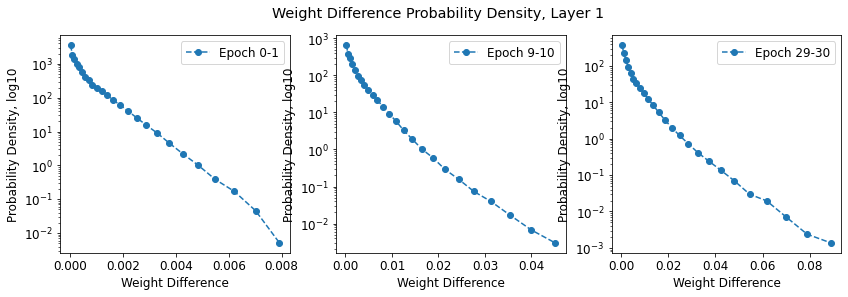

In [70]:
plt.figure(figsize=(14, 4))
plt.suptitle("Weight Difference Probability Density, Layer 1")

plt.subplot(1, 3, 1)
plt.plot(bin_centers_0_1, prob_density_0_1, "o--", label="Epoch 0-1")
plt.legend()
plt.yscale("log")
plt.xlabel("Weight Difference, $\Delta w$")
plt.ylabel("Probability Density, log10")

plt.subplot(1, 3, 2)
plt.plot(bin_centers_9_10, prob_density_9_10, "o--", label="Epoch 9-10")
plt.legend()
plt.yscale("log")
plt.xlabel("Weight Difference, $\Delta w$")
plt.ylabel("Probability Density, log10")

plt.subplot(1, 3, 3)
plt.plot(bin_centers_29_30, prob_density_29_30, "o--", label="Epoch 29-30")
plt.legend()
plt.yscale("log")
plt.xlabel("Weight Difference, $\Delta w$")
plt.ylabel("Probability Density, log10")
plt.show()

Tilnærmet lineær graf i log-log plot antyder ekspoentsiell sammenheng.

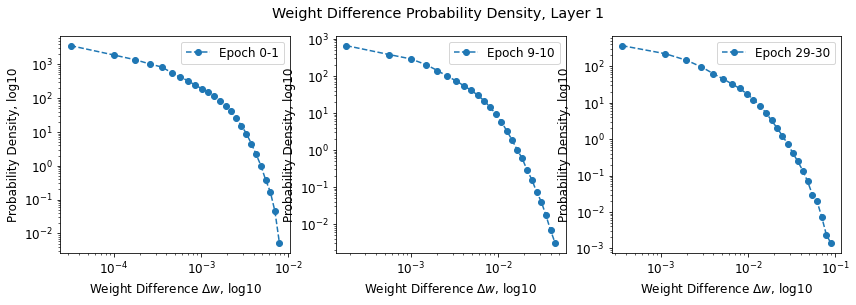

In [138]:
plt.figure(figsize=(14, 4))
plt.suptitle("Weight Difference Probability Density, Layer 1")

plt.subplot(1, 3, 1)
plt.plot(bin_centers_0_1, prob_density_0_1, "o--", label="Epoch 0-1")
plt.legend()
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Weight Difference $\Delta w$, log10")
plt.ylabel("Probability Density, log10")

plt.subplot(1, 3, 2)
plt.plot(bin_centers_9_10, prob_density_9_10, "o--", label="Epoch 9-10")
plt.legend()
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Weight Difference $\Delta w$, log10")
plt.ylabel("Probability Density, log10")

plt.subplot(1, 3, 3)
plt.plot(bin_centers_29_30, prob_density_29_30, "o--", label="Epoch 29-30")
plt.legend()
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Weight Difference $\Delta w$, log10")
plt.ylabel("Probability Density, log10")
plt.show()

Siden sannsynlighetstetthetsplottene ser ut som en eksponentsiell-funksjon med lineær x- og y-akse, deretter blir omtrent rette med logaritmisk y-akse og så ekspoentsielle igjen for logaritmisk y-akse og x-akse ser det ut som om vi har med en eksponentialfunksjon å gjøre. https://courses.lumenlearning.com/ccbcmd-math-1/chapter/graphs-of-exponential-and-logarithmic-functions/

Det er likevel uklart for meg hvorfor det siste plottet som er rett ovenfor er diagonalt speilet av det første lin-lin (lineære akser) plottet. Det kan også diskuteres om lin-log plottene faktisk er rette da vi kan se at de fleste datapunktene ligger på en litt kurvet linje øverst i venstre hjørne av plottet.

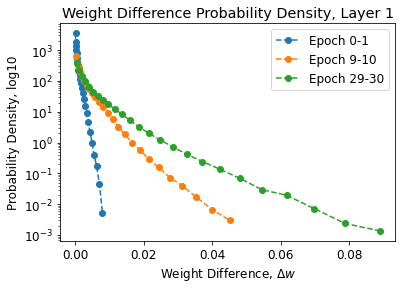

In [147]:
plt.plot(bin_centers_0_1, prob_density_0_1, "o--", label="Epoch 0-1")
plt.plot(bin_centers_9_10, prob_density_9_10, "o--", label="Epoch 9-10")
plt.plot(bin_centers_29_30, prob_density_29_30, "o--", label="Epoch 29-30")

plt.xlabel("Weight Difference, $\Delta w$")
plt.ylabel("Probability Density, log10")
plt.title("Weight Difference Probability Density, Layer 1")
plt.legend()
plt.yscale("log")
#plt.xscale("log")
#plt.xlim(0, 0.01)
#plt.ylim(0, 1000)
plt.show()

Vi ser at når vi plotter alle sannsynlighetstetthetene i samme plot med logaritmisk y-akse er det stor forskjell på vektendringene etter nettverket trenes.

### 17. juli

Prøvde å finne mer ut av den karakteristike størrelsen $\Delta w^*$ som definert øverst i notebooken og hvordan den er definert for de ulike fordelingsfunksjonene. 

Fikk lastet opp hele pprosjektet på en felles github-repo slik at de andre kan se hva jeg har gjort.